# SHAP 실습 (2)
## - 문제: Sentiment Analysis
* 영화 리뷰에서 긍정, 부정적인 감정을 분류

## - 데이터셋: IMDB dataset
* 긍정적 또는 부정적인 감정을 표현하는 영화 리뷰 50,000개로 구성
* 각 감정 별 25,000개의 리뷰를 포함
* 훈련용 데이터와 테스트용 데이터로 나뉘어 제공됨

## - 주요 특징
* 균형 잡힌 데이터셋: 긍정 리뷰와 부정 리뷰가 각각 50%씩 포함되어 있어, 데이터 불균형 문제를 피할 수 있음
* 실제 사용자 리뷰: 실제 영화 관람자들이 작성한 리뷰를 바탕으로 하여, 자연스러운 언어 스타일과 다양한 표현을 포함
* 텍스트 데이터: 리뷰는 텍스트 형태로 제공. 주로 영어로 되어 있음

## (1) Logistic Regression 모델 학습 후, 분석

In [ ]:
!pip install shap

In [ ]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap

### 1. 데이터 불러오기

In [ ]:
# 데이터 불러오기
corpus, y = shap.datasets.imdb() # corpus: 리뷰 텍스트, y: 긍정적/부정적 평가
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)

# 텍스트 벡터
vectorizer = TfidfVectorizer(min_df=10) # 문서 빈도가 10 이하인 단어는 벡터화 과정에서 제외
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)


### 2. Logistic regression 모델 학습

In [ ]:
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1)

- `penalty="l2"`: 모델의 오버피팅을 방지하기 위해 L2 정규화를 사용하겠다는 뜻
- `C=0.1`: 정규화 강도를 제어하는 인자. C값이 낮을수록 정규화 강도가 높아져 모델이 단순해진다.

### 3. 모델 설명하기

In [ ]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray() # Sparse array -> Dense array

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


- `feature_perturbation="interventional"`: 데이터 집합에서 한 특성의 값을 변경하면서 모델의 반응을 관찰하여 해당 특성의 영향력을 평가

모든 피처의 영향력 요약하기

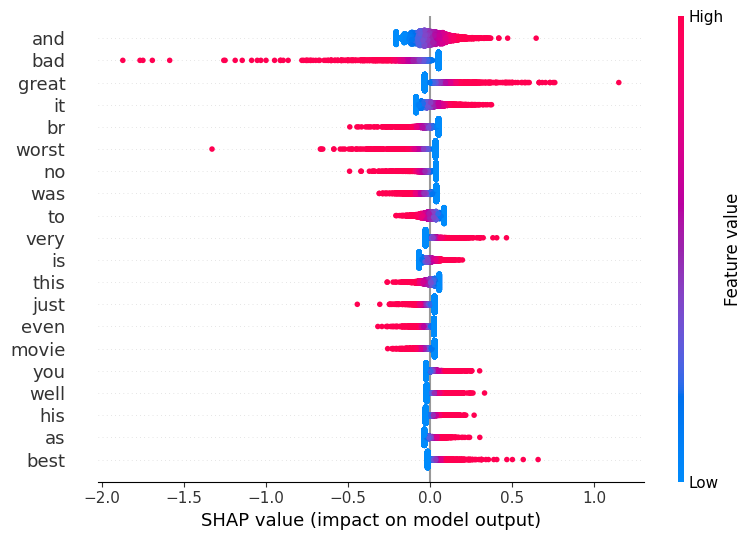

In [ ]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names_out(), plot_size=0.2)

첫번째 리뷰의 감정 예측 설명하기

In [ ]:
shap.initjs()

ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names_out()
)

- 가장 큰 영향도를 가진 단어는 and와 it
- 데이터를 구성하고 있는 단어들이 너무 많아서 두 단어를 제외한 나머지 단어들은 생략되어서 나오고 있다.
- => 생략된 정보를 살펴보기 위해서 waterfall_plot을 그려보자

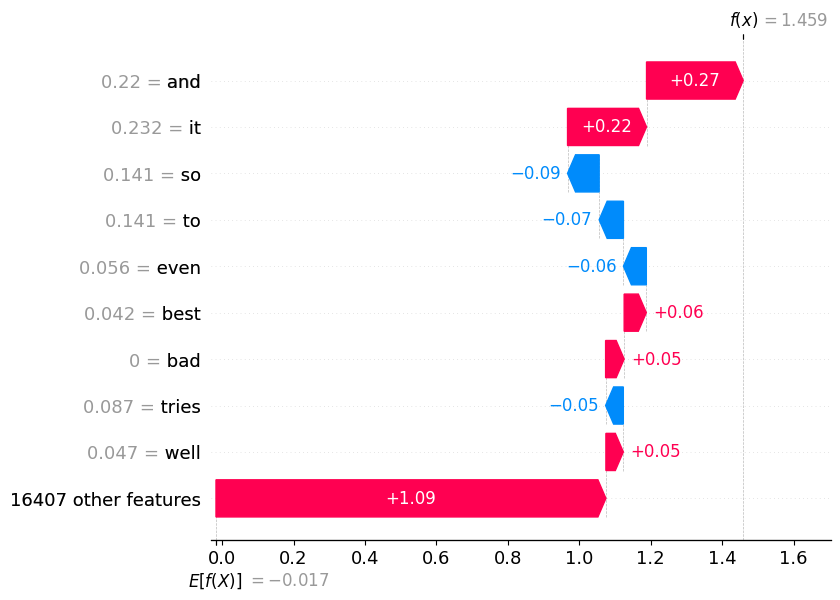

In [ ]:
shap.waterfall_plot(
    shap.Explanation(
        shap_values[ind], explainer.expected_value, X_test_array[ind],
        feature_names=vectorizer.get_feature_names_out()
    )
)

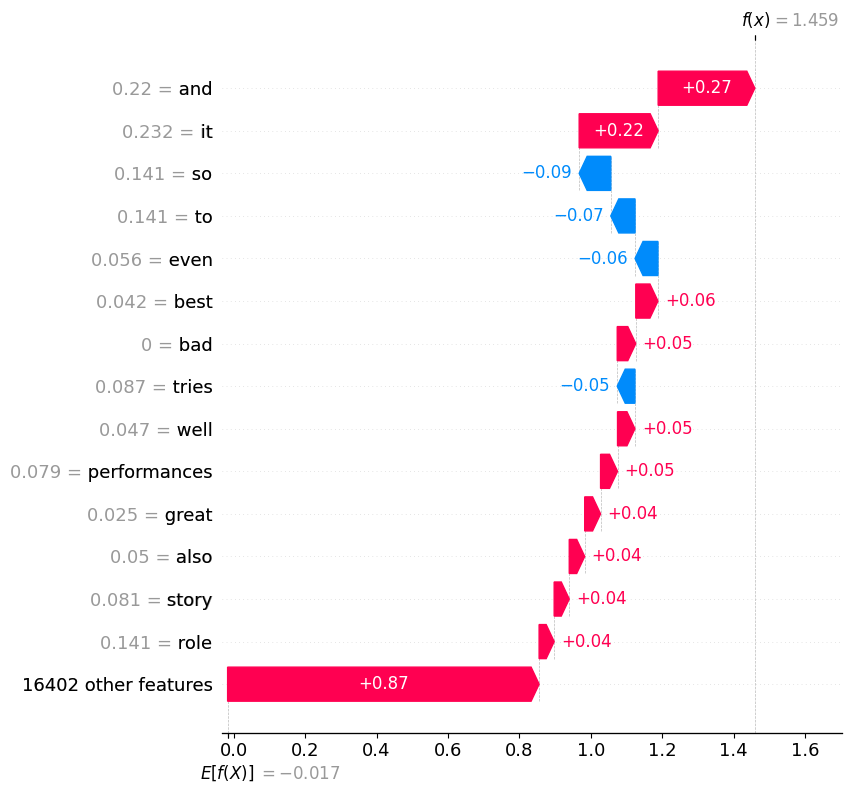

In [ ]:
shap.waterfall_plot(
    shap.Explanation(
        shap_values[ind], explainer.expected_value, X_test_array[ind],
        feature_names=vectorizer.get_feature_names_out()),
    max_display=15
)

In [ ]:
print("Positive" if y_test[ind] else "Negative", "Review:")
print(corpus_test[ind])

Positive Review:
"Twelve Monkeys" is odd and disturbing, yet being so clever and intelligent at the same time. It cleverly jumps between future and the past, and the story it tells is about a man named James Cole, a convict, who is sent back to the past to gather information about a man-made virus that wiped out 5 billion of the human population on the planet back in 1996. At first Cole is sent back to the year 1990 by accident and by misfortune he is taken to a mental institution where he tries to explain his purpose and where he meets a psychiatrist Dr. Kathryn Railly who tries to help him and a patient named Jeffrey Goines, the insane son of a famous scientist. Being provocative and somehow so sensible, dealing with and between reason and madness, the movie is a definite masterpiece in the history of science-fiction films.<br /><br />The story is just fantastic. It's so original and so entertaining. The screenplay itself written by David and Janet Peoples is inspired by a movie name

## 문제: League of Legends Win Prediction

## - 데이터셋: League of Legends Ranked Matches
* 2014년부터 시작된 리그 오브 레전드의 랭크 게임 180,000 게임을 포함
* 플레이어가 매치를 어떻게 플레이했는지에 대한 통계를 기반으로 플레이어의 팀이 승리할지 예측

## - 주요 특징
* 플레이어 정보: 각 플레이어의 소환사 이름, 티어, 승/패 기록 등
* 챔피언 정보: 플레이어가 선택한 챔피언, 챔피언의 레벨, 사용한 스킬 등
* 게임 통계: 킬, 데스, 어시스트, 마지막 타격, 미니언 처치 수, 골드 획득량, 구입한 아이템, 시야 점수 등
* 게임 결과: 승리 또는 패배, 게임 시간, 최종 점수 등
* 맵과 게임 모드: 플레이된 맵의 종류, 게임 모드(예: 솔로 랭크, 팀 랭크) 등
* 팀 정보: 팀 구성, 각 팀의 총 킬 수, 바론, 드래곤 등 몬스터의 처치 정보 등

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

### Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
prefix = "./drive/MyDrive/기타/league-of-legends-ranked-matches/"
matches = pd.read_csv(prefix+"matches.csv")
participants = pd.read_csv(prefix+"participants.csv")
stats1 = pd.read_csv(prefix+"stats1.csv", low_memory=False)
stats2 = pd.read_csv(prefix+"stats2.csv", low_memory=False)
stats = pd.concat([stats1,stats2])

# 데이터 프레임 통합
a = pd.merge(participants, matches, left_on="matchid", right_on="id")
allstats_orig = pd.merge(a, stats, left_on="matchid", right_on="id")
allstats = allstats_orig.copy()

# 10분 미만 경기는 데이터에서 제외
allstats = allstats.loc[allstats["duration"] >= 10*60,:]

# 문자열 기반 범주형 데이터를 숫자 코드로 변환
cat_cols = ["role", "position", "version", "platformid"]
for c in cat_cols:
    allstats[c] = allstats[c].astype('category')
    allstats[c] = allstats[c].cat.codes
allstats["wardsbought"] = allstats["wardsbought"].astype(np.int32)

X = allstats.drop(["win"], axis=1)
y = allstats["win"]

In [ ]:
# [14]
# 이벤트들 중 분당 값(rate per minute)로 변환할 특징들을 처리
rate_features = [
    "kills", "deaths", "assists", "killingsprees", "doublekills",
    "triplekills", "quadrakills", "pentakills", "legendarykills",
    "totdmgdealt", "magicdmgdealt", "physicaldmgdealt", "truedmgdealt",
    "totdmgtochamp", "magicdmgtochamp", "physdmgtochamp", "truedmgtochamp",
    "totheal", "totunitshealed", "dmgtoobj", "timecc", "totdmgtaken",
    "magicdmgtaken" , "physdmgtaken", "truedmgtaken", "goldearned", "goldspent",
    "totminionskilled", "neutralminionskilled", "ownjunglekills",
    "enemyjunglekills", "totcctimedealt", "pinksbought", "wardsbought",
    "wardsplaced", "wardskilled"
]
for feature_name in rate_features:
    X[feature_name] /= X["duration"] / 60

# 게임 지속시간 대비 비율로 변환
X["longesttimespentliving"] /= X["duration"]

# define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingsprees": "Killing sprees per min.",
    "longesttimespentliving": "Longest time living as % of game",
    "doublekills": "Double kills per min.",
    "triplekills": "Triple kills per min.",
    "quadrakills": "Quadra kills per min.",
    "pentakills": "Penta kills per min.",
    "legendarykills": "Legendary kills per min.",
    "totdmgdealt": "Total damage dealt per min.",
    "magicdmgdealt": "Magic damage dealt per min.",
    "physicaldmgdealt": "Physical damage dealt per min.",
    "truedmgdealt": "True damage dealt per min.",
    "totdmgtochamp": "Total damage to champions per min.",
    "magicdmgtochamp": "Magic damage to champions per min.",
    "physdmgtochamp": "Physical damage to champions per min.",
    "truedmgtochamp": "True damage to champions per min.",
    "totheal": "Total healing per min.",
    "totunitshealed": "Total units healed per min.",
    "dmgtoobj": "Damage to objects per min.",
    "timecc": "Time spent with crown control per min.",
    "totdmgtaken": "Total damage taken per min.",
    "magicdmgtaken": "Magic damage taken per min.",
    "physdmgtaken": "Physical damage taken per min.",
    "truedmgtaken": "True damage taken per min.",
    "goldearned": "Gold earned per min.",
    "goldspent": "Gold spent per min.",
    "totminionskilled": "Total minions killed per min.",
    "neutralminionskilled": "Neutral minions killed per min.",
    "ownjunglekills": "Own jungle kills per min.",
    "enemyjunglekills": "Enemy jungle kills per min.",
    "totcctimedealt": "Total crown control time dealt per min.",
    "pinksbought": "Pink wards bought per min.",
    "wardsbought": "Wards bought per min.",
    "wardsplaced": "Wards placed per min.",
    "turretkills": "# of turret kills",
    "inhibkills": "# of inhibitor kills",
    "dmgtoturrets": "Damage to turrets"
}
feature_names = [full_names.get(n, n) for n in X.columns]
X.columns = feature_names

In [ ]:
Xt, Xv, yt, yv = train_test_split(X,y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

### XGBoost 모델 학습

In [ ]:
params = {
    "eta": 0.5, # 학습률
    "max_depth": 4, # 트리 최대 깊이
    "objective": "binary:logistic", # 이진 분류
    "silent": 1, # 경고 메시지 생략
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model = xgb.train(params, dt, 300, [(dt, "train"),(dv, "valid")], early_stopping_rounds=5, verbose_eval=25)

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:771: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [07:27:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "silent" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-logloss:0.54147	valid-logloss:0.54146
[25]	train-logloss:0.28916	valid-logloss:0.28950
[50]	train-logloss:0.25479	valid-logloss:0.25632
[75]	train-logloss:0.23665	valid-logloss:0.23895
[100]	train-logloss:0.22484	valid-logloss:0.22781
[125]	train-logloss:0.21495	valid-logloss:0.21866
[150]	train-logloss:0.20707	valid-logloss:0.21150
[175]	train-logloss:0.19964	valid-logloss:0.20463
[200]	train-logloss:0.19296	valid-logloss:0.19856
[225]	train-logloss:0.18677	valid-logloss:0.19287
[250]	train-logloss:0.18128	valid-logloss:0.18795
[275]	train-logloss:0.17572	valid-logloss:0.18268
[299]	train-logloss:0.17082	valid-logloss:0.17823


### XGBoost 모델 설명하기

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

#### 특정 플래이어가 특정 게임에서 승리할 가능성을 설명하기

In [ ]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0,:], Xv.iloc[0,:])

- 승리 예측 결과: 3.3 <= tree shap은 출력이 단순 확률값이 아닌 로그 확률 비율로 계산된다
- 로그 확률의 변화가 승리 확률로 어떻게 변환되는지 그래프를 통해 살펴보자.

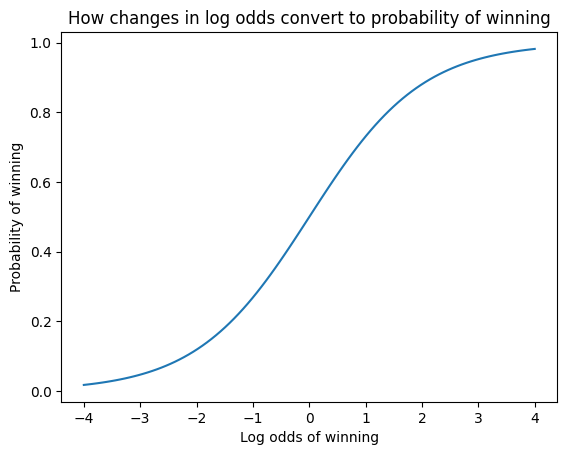

In [ ]:
xs = np.linspace(-4,4,100)
plt.xlabel("Log odds of winning")
plt.ylabel("Probability of winning")
plt.title("How changes in log odds convert to probability of winning")
plt.plot(xs, 1/(1+np.exp(-xs)))
plt.show()

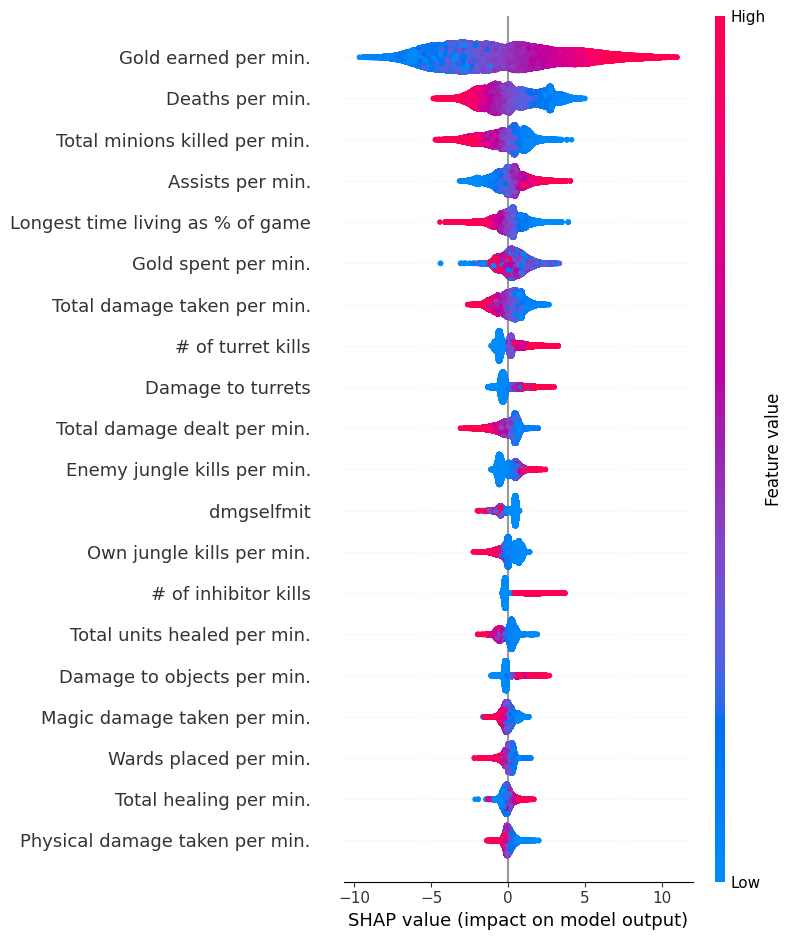

In [ ]:
# 전체 데이터셋에 대한 모든 특성의 영향 요약
shap.summary_plot(shap_values, Xv)

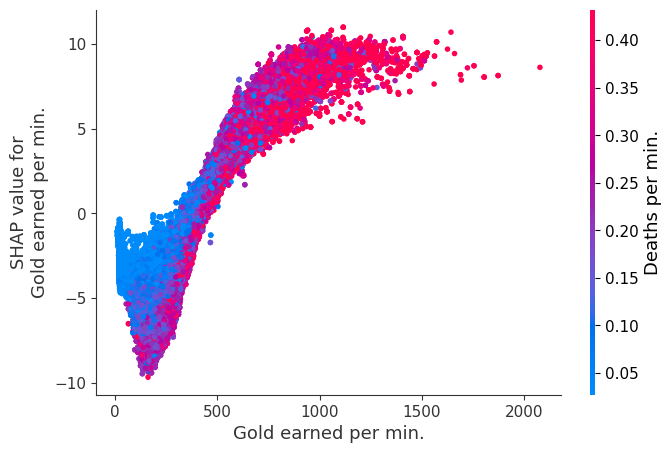

In [ ]:
shap.dependence_plot("Gold earned per min.", shap_values, Xv, interaction_index="Deaths per min.")

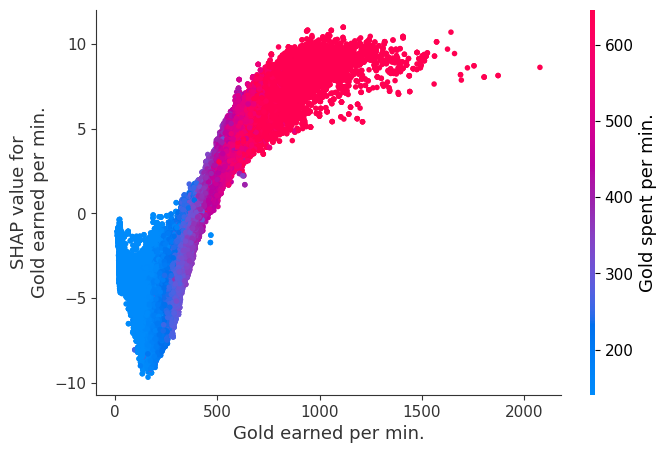

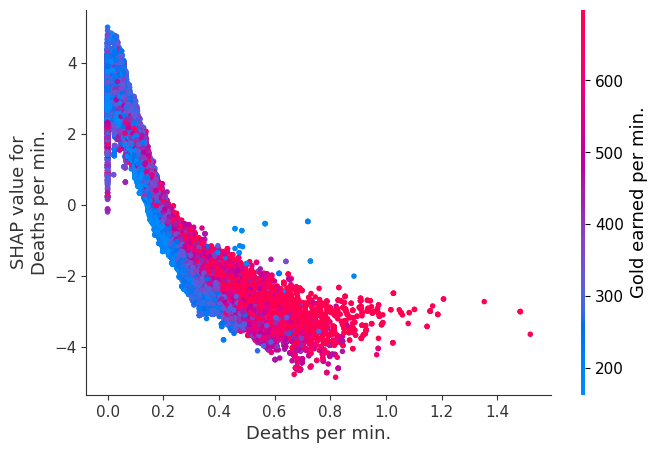

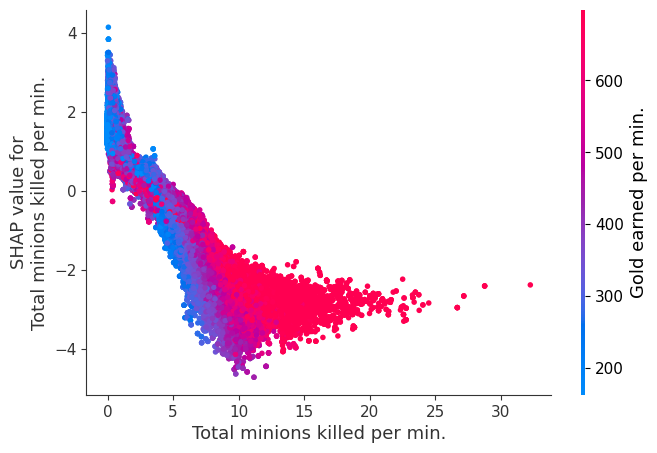

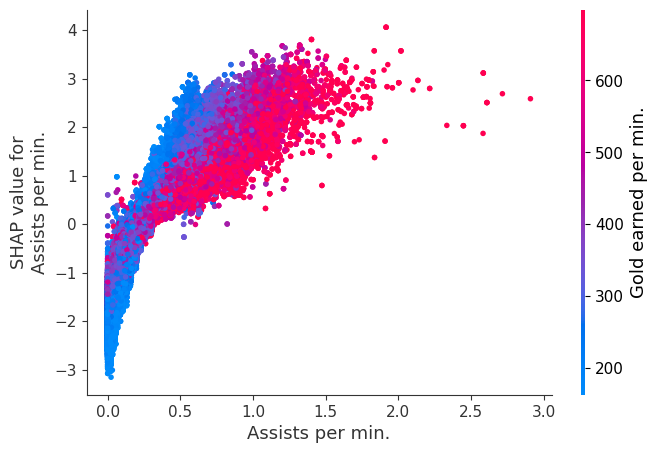

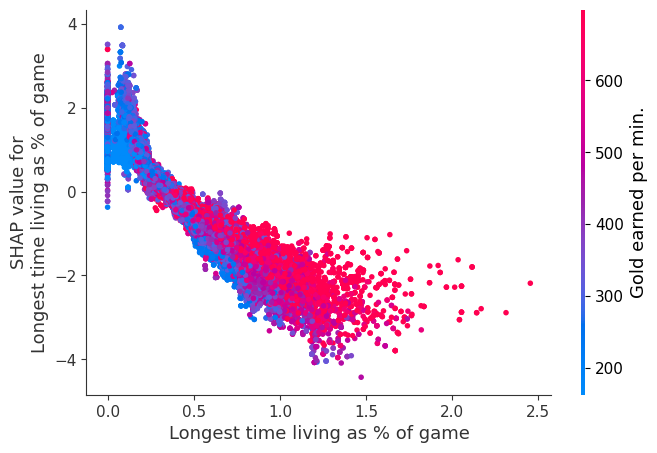

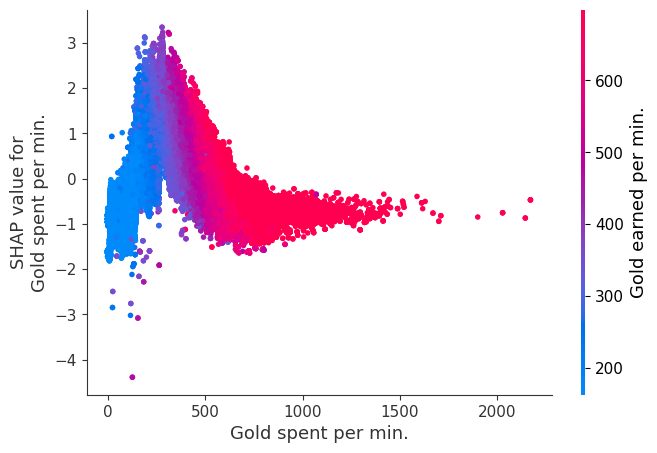

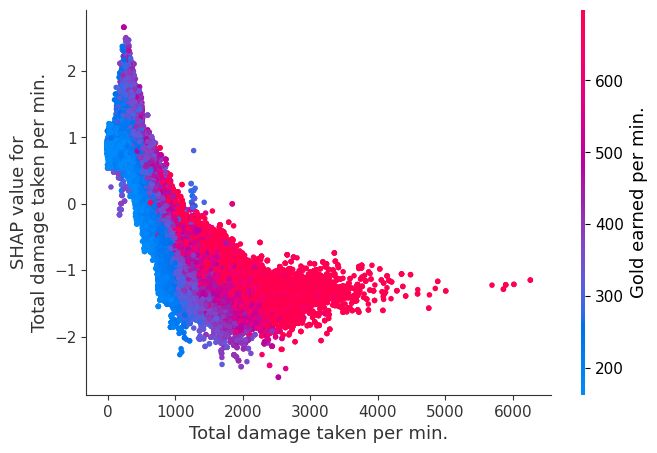

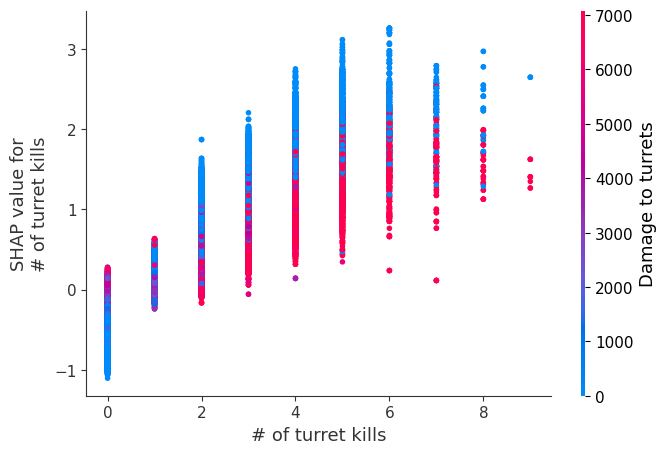

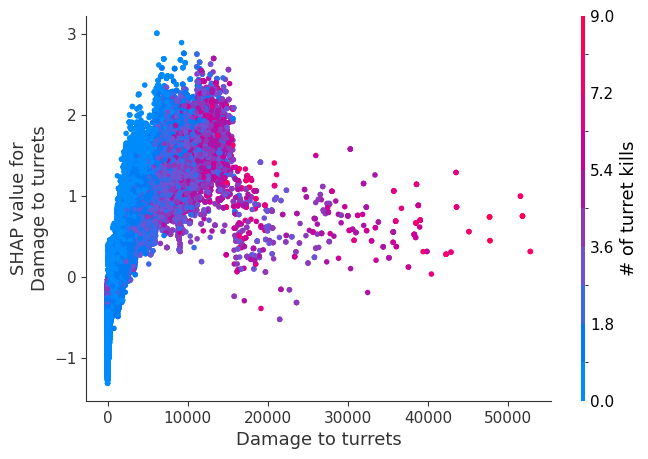

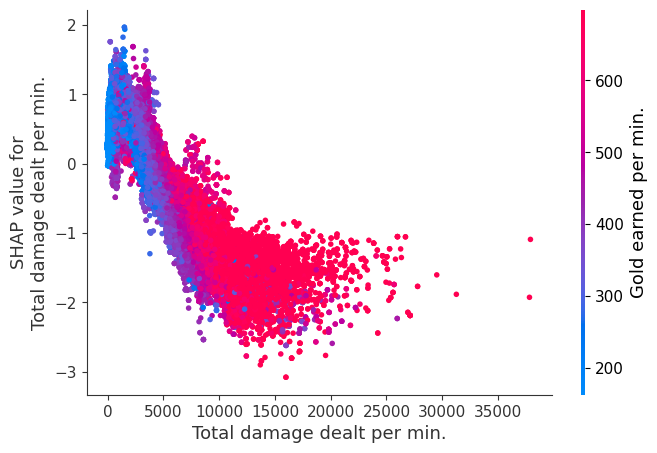

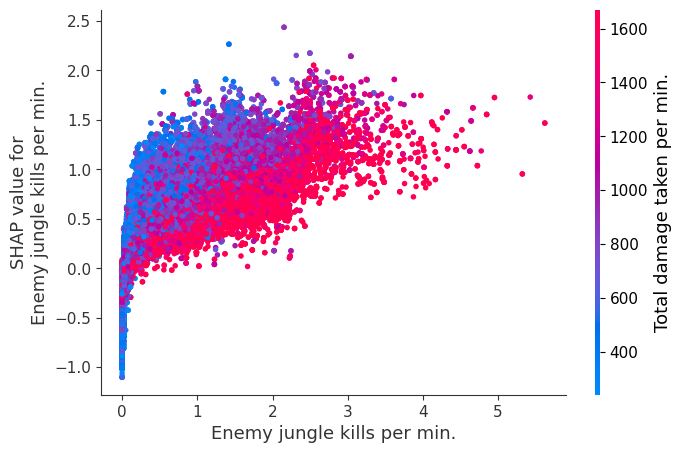

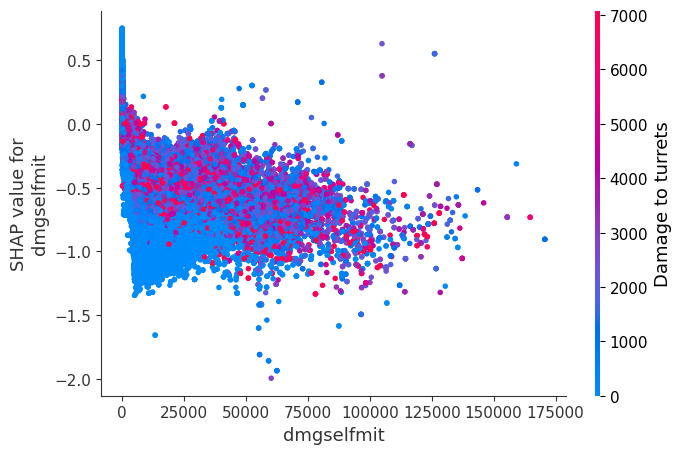

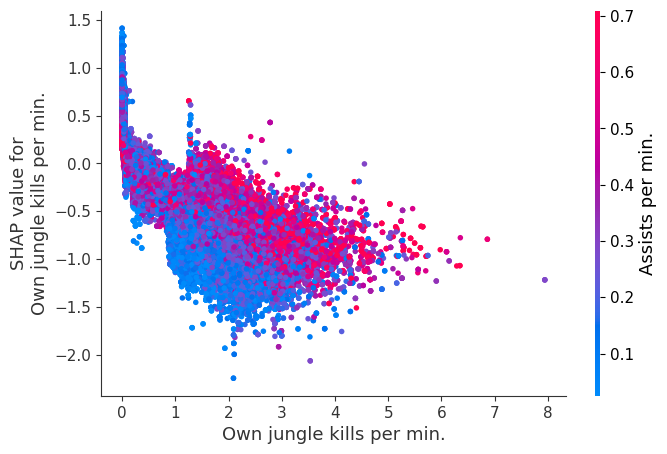

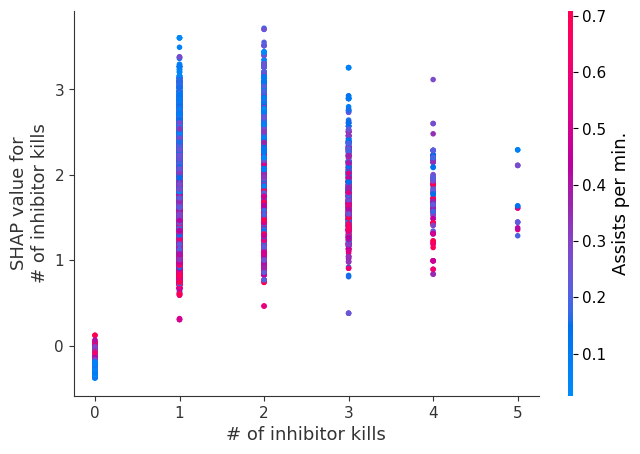

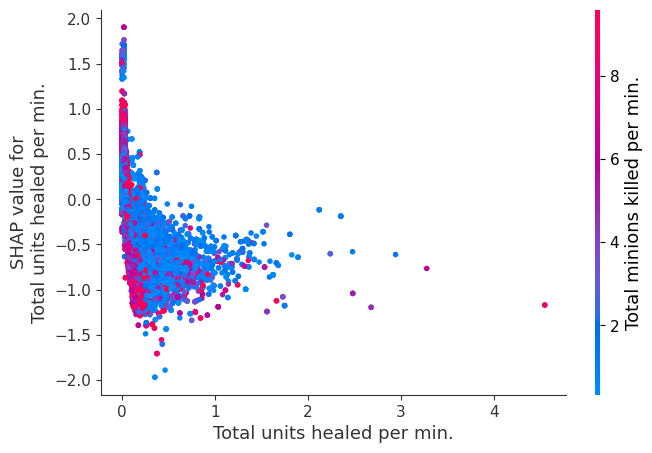

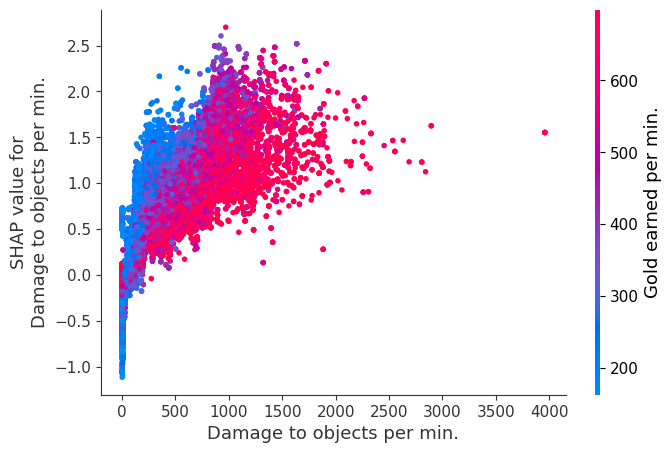

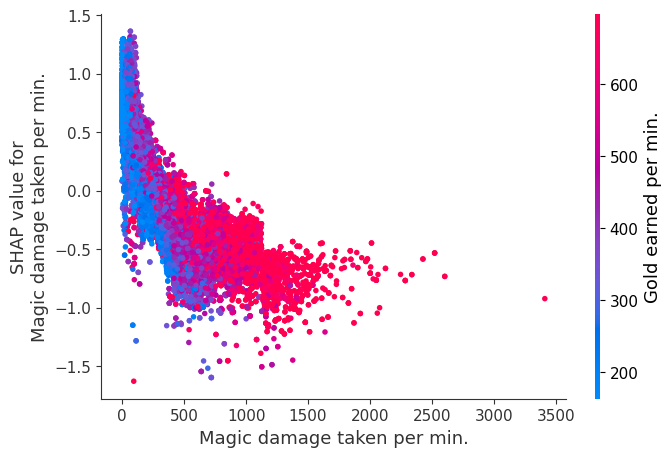

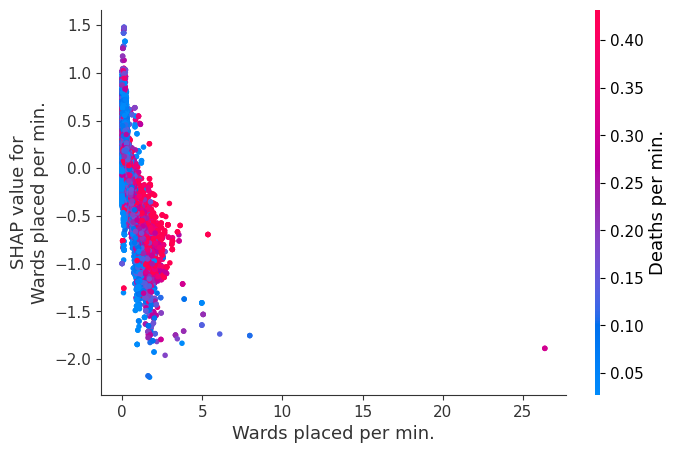

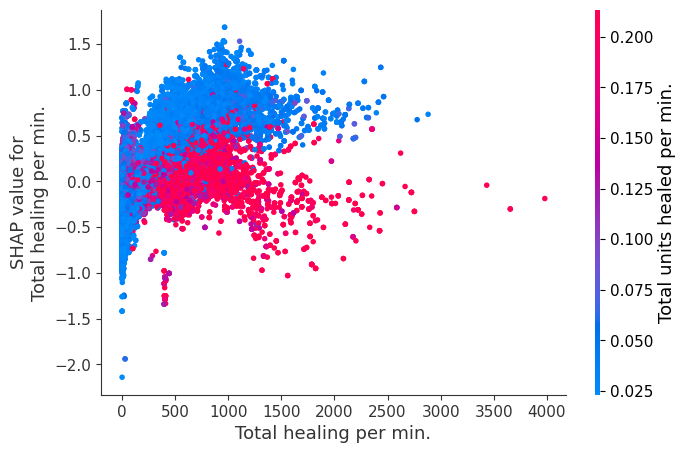

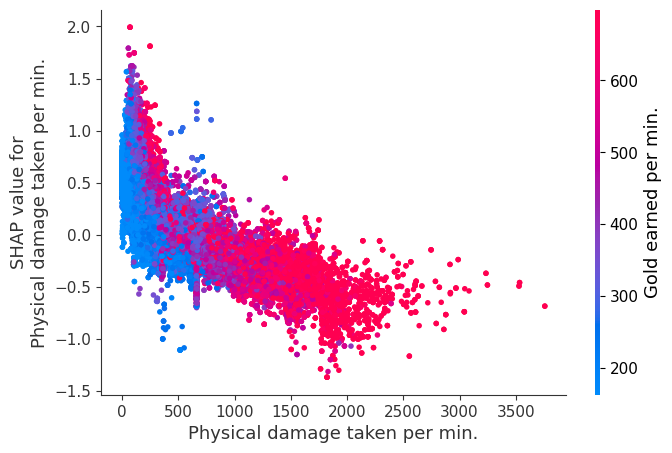

In [ ]:
# 특성들의 중요도를 순위를 매김
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# 20개 주요 특성들에 대한 dependence plot 그리기
for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, Xv)